In [1]:
import matplotlib.pyplot as plt
import numpy as np
#from mpl_toolkits.mplot2d import axes3d #tool for 3d plotting
import matplotlib.animation as animation
from scipy.stats import norm
from PIL import Image #tool for naimating 3d plotting
from matplotlib import cm

In [2]:
### Quick and dirty try of convolved FD-FLIM with gaussian PSF and MSSR ###

#### MSSR code ####

#Bicubic Interpolation
def bicInter(img, amp, mesh):
	width, height = img.shape
	y=np.linspace(1, width, width)
	x=np.linspace(1, height, height)
	imgInter=interpolate.interp2d(x, y, img, kind='cubic')
	y2=np.linspace(1, width, width*amp)
	x2=np.linspace(1, height, height*amp)
	Z2 = imgInter(x2, y2)
	if mesh:
		Z2 = meshing(Z2, amp)
	return Z2

#Fourier Interpolation
def ftInterp(img, amp, mesh):
	width, height = img.shape
	mdX = math.ceil(width/2) + 1
	mdY = math.ceil(height/2) + 1 
	
	extraBorder = math.ceil(amp/2)
	Nwidth = (width*amp) + extraBorder
	Nheight = (height*amp) + extraBorder
	
	lnX = len(np.arange((mdX),width))
	lnY = len(np.arange((mdY),height))
	
	imgFt = np.fft.fft2(img)
	imgFt = imgFt * (Nwidth/width) * (Nheight/height)
#	imgFt = imgFt * amp * amp
	
	fM = np.zeros((Nwidth, Nheight), dtype=complex)
	fM[0:mdX, 0:mdY] = imgFt[0:mdX, 0:mdY]; #izq sup cuadrante
	fM[0:mdX, (Nheight-lnY):Nheight] = imgFt[0:mdX, (mdY):height]; #der sup cuadrante
	fM[(Nwidth-lnX):Nwidth, 0:mdY] = imgFt[(mdX):width, 0:mdY]; #izq inf cuadrante
	fM[(Nwidth-lnX):Nwidth, (Nheight-lnY):Nheight] = imgFt[(mdX):width, (mdY):height]; #der inf cuadrante

	Z2 = (np.fft.ifft2(fM)).real
	Z2 = Z2[0:(width*amp), 0:(height*amp)]
	if mesh:
		Z2 = meshing(Z2, amp)
	return Z2

#Mesh compensation
def meshing(img, amp):
    width, height = img.shape
    desp = math.ceil(amp/2)
    imgPad = np.pad(img, desp, 'symmetric')
    imgS1 = imgPad[0:width, desp:height+desp]
    imgS2 = imgPad[(desp*2):width+(desp*2), desp:height+desp]
    imgS3 = imgPad[desp:width+desp, 0:height]
    imgS4 = imgPad[desp:width+desp, (desp*2):height+(desp*2)]
    imgF = (img + imgS1 + imgS2 + imgS3 + imgS4) / 5
    return imgF

#Spatial MSSR
def sfMSSR(img, fwhm, amp, order, mesh = True, ftI = False, intNorm = True):
	hs = round(0.5*fwhm*amp)
	if hs < 1:
		hs = 1
	maxValueImgOr = (max(map(max, img)))
	if(amp > 1 and not ftI):
		img = bicInter(img, amp, mesh)
	elif(amp > 1 and ftI):
		img = ftInterp(img, amp, mesh)
	width, height = img.shape
	xPad = np.pad(img, hs, 'symmetric')
	M = np.zeros((width,height))
	for i in range(-hs, hs+1):
		for j in range(-hs, hs+1):
			if i!=0 or j!=0:
				xThis = xPad[hs+i:width+hs+i, hs+j:height+hs+j]
				M = np.maximum(M, np.absolute(img-xThis))

	weightAccum = np.zeros((width,height))
	yAccum = np.zeros((width,height))

	for i in range(-hs, hs+1):
		for j in range(-hs, hs+1):
			if i!=0 or j!=0:
				spatialkernel = np.exp(-(pow(i,2)+pow(j,2))/pow((hs),2))
				xThis = xPad[hs+i:width+hs+i, hs+j:height+hs+j]
				xDiffSq0 = pow((img-xThis)/M,2)
				intensityKernel = np.exp(-xDiffSq0)

				weightThis = spatialkernel*intensityKernel
				weightAccum = weightAccum + weightThis
				yAccum = yAccum + (xThis*weightThis)

	MS = img - (yAccum/weightAccum)
	MS[MS < 0] = 0
	MS[np.isnan(MS)] = 0

	I3 = MS/(max(map(max, MS)))
	x3 = img/(max(map(max, img)))
	for i in range(order):
		I4 = x3 - I3
		I5 = max(map(max, I4)) - I4
		I5 = I5/max(map(max, I5))
		I6 = I5*I3
		I7 = I6/max(map(max, I6))
		x3 = I3
		I3 = I7
	I3[np.isnan(I3)] = 0
	if intNorm:
		IMSSR = I3*img
	else:
		IMSSR = I3
	return IMSSR

#Temporal MSSR
def tMSSR(img_layer, fwhm, amp, order, mesh = True, ftI = False, intNorm = True):
	img=np.array(img_layer.data)
	nFrames, width, height = img.shape
	imgMSSR = np.zeros((nFrames,width*amp,height*amp))
	for nI in range(nFrames):
		print("Image " + str(nI+1))
		imgMSSR[nI, :, :] = sfMSSR(img[nI], fwhm, amp, order, mesh, ftI, intNorm)
	return imgMSSR

#Mean
def tMean(img):
	return np.mean(img, 0)

#Variance
def tVar(img):
	return np.var(img, 0)

#Temporal Product Mean
def TPM(img):
    nFrames, width, height = img.shape
    SumTPM = np.zeros((width,height))
    iTPM = np.zeros((width,height))
    for i in range(nFrames):
        SumTPM = SumTPM + img[i]
    for i in range(nFrames):
        iTPM = iTPM + (SumTPM * img[i])
    return iTPM

#Auto-Cummulants
def TRAC(img, k):
    nFrames, width, height = img.shape
    avg = np.mean(img, 0)
    d0 = np.absolute(img - avg)
    d1 = d0[1:nFrames, :, :]
    d2 = d0[2:nFrames, :, :]
    d3 = d0[3:nFrames, :, :]
    if k == 2:
        trac = np.mean(d0[1:nFrames, :, :]*d1,0)
    elif k == 3:
        trac = np.mean(d0[2:nFrames, :, :]*d1[1:nFrames, :, :]*d2,0)
    else:
        t1 = np.mean(d0[3:nFrames, :, :]*d1[2:nFrames, :, :]*d2[1:nFrames, :, :]*d3,0)
        t2 = np.mean(d0[3:nFrames, :, :]*d1[2:nFrames, :, :],0)*np.mean(d2[1:nFrames, :, :]*d3,0)
        t3 = np.mean(d0[3:nFrames, :, :]*d2[1:nFrames, :, :],0)*np.mean(d1[2:nFrames, :, :]*d3,0)
        t4 = np.mean(d0[3:nFrames, :, :]*d3,0)*np.mean(d1[2:nFrames, :, :]*d2[1:nFrames, :, :],0)
        trac = np.absolute(t1-t2-t3-t4)
    return trac

#Empirical cumulative distribution function
def ecdf(data):
	""" Compute ECDF """
	data = np.reshape(data, -1)
	x = np.sort(data)
	n = len(x)
	y = np.arange(1, n+1) / n
	return(x,y)

#Exclude Outliers
def excOutliers(data, th):
	th = (100 - th)/100
	x, f = ecdf(data)
	found = np.where(f > th)
	mnX = x[found[0][0]];
	data = np.where(data >= mnX, mnX, data)
	return data

In [3]:
def fd_flim_gauss_mssr(tau_1,tau_2,mu1, s1, mssr_order):
    # First the FD-FLIM part
    E_0 = 1 #Steady-state intensity. Arbitrary units
    E_w = 1 #Amplitude of the time-varying intensity. Arbitrary units
    T = 10 # time in nanoseconds. Period of repetition of the excitation light, for a 1.0 ns probe one can use ~100MHz frequency, so 10 ns
    phi_E = 0 #phase of the excitation light. angle in grads
    ### Function E(t) ###
    w = (2*np.pi)/T
    t = np.arange(0, 40, 0.1)
    E_t = E_0 + E_w*np.cos(w*t + phi_E)
    ### Emission F(t) ###
    # The fluorescence emission at time , t is
    # F(t) = E_0*a_s*tau_s + E_w*a_s*tau_s*Ms*cos(w*t + phi_E - phi_F)
    F = 100000000                                   # Frequency of the excitation light. In Hz
    a_s = 1.0                                       # fractional number from 0.0 to 1.0 indicating how much of the signal
                                                    # corresponds to a specific fluorophore emission 
    #tau_1 = float(input('Enter a fluorescence lifetime, \u03C4_1, in ns (from 0.05 to 100, two decimal figures allowed): '))  # lifetime in ns
    #tau_2 = float(input('Enter a fluorescence lifetime, \u03C4_2, in ns (from 0.05 to 100, two decimal figures allowed): '))  # lifetime in ns
    Ms_1 = 1 / np.sqrt(1 + (w*tau_1)**2)
    Ms_2 = 1 / np.sqrt(1 + (w*tau_2)**2)
    phi_F1 = np.radians(2*np.pi*F*tau_1)             # phi_F is the phase in rad from the tau_s as
                                                     # phi_F = 2*pi*F*tau_s, where F for tau = 1.0ns is 100MHz = 100 000 000 s^(-1)
    phi_F2 = np.radians(2*np.pi*F*tau_2)
    F_t1 = E_0*a_s*tau_1 + E_w*a_s*tau_1*Ms_1*np.cos(w*t + phi_E - phi_F1)
    F_t2 = E_0*a_s*tau_2 + E_w*a_s*tau_2*Ms_2*np.cos(w*t + phi_E - phi_F2)
    # Let's normalize the functions above #
    max_E = max(E_t)
    norm_E = E_t/max_E
    max_F1 = max(F_t1)
    norm_F1 = F_t1/max_F1                 # Normalized F_t1 but it has a maximum value of 1.0, so the entire plot is levered to that number
    mod_F1 = (F_t1/max_F1)*Ms_1           # Multiplying norm_F1 by the modulation Ms_1, then it returns the plot to the maximum value of M_f
    max_F2 = max(F_t2)
    norm_F2 = F_t2/max_F2                 # Normalized F_t2 but it has a maximum value of 1.0, so the entire plot is levered to that number
    mod_F2 = (F_t2/max_F2)*Ms_2
    # Adding the AC/DC lines to calculate the modulation shift #
    mean_E = np.mean(norm_E)
    mean_F1 = np.mean(mod_F1)
    max_E = max(norm_E)
    max_F1 = max(mod_F1)
    mean_F2 = np.mean(mod_F2)
    max_F2 = max(mod_F2)
    ### AC lines ###
    ACex = max_E - mean_E
    ACem1 = max_F1 - mean_F1
    ACem2 = max_F2 - mean_F2
    DCex = mean_E - 0.0
    DCem1 = mean_F1 - 0.0
    DCem2 = mean_F2 - 0.0
    ### Modulation and lifetime from AC/DC ratio ###
    Mod1 = (ACem1/DCem1)/(ACex/DCex)
    tau_mod1 = (np.sqrt(1 - Mod1**2))/(Mod1*w)
    Mod2 = (ACem2/DCem2)/(ACex/DCex)
    tau_mod2 = (np.sqrt(1 - (Mod2)**2))/(Mod2*w)
    ### Error calculation ###
    Mod1_err = (abs(Ms_1-Mod1)/Ms_1)*100
    tau1_err = (abs(tau_1-tau_mod1)/tau_1)*100
    Mod2_err = (abs(Ms_2-Mod2)/Ms_2)*100
    tau2_err = (abs(tau_2-tau_mod2)/tau_2)*100
    #From the above, the most important part is the Mod value which is going to be multiplied by the normalized gauss
    # Calculation of rMod from the equation
    # rMod = 0.5316*rtau + 0.4684, where rMod = Mod(tau_1)/Mod(tau_2)
    rtau = tau_mod2/tau_mod1
    rMod = 0.5316*rtau + 0.4684
    # Now, the gauss part
    n = 1500
    x = np.linspace(-n, n, n)
    #mu1 = float(input('Enter a value in which you whish the gaussian function to be centered (from 0 to 1000 in multiples of 100): '))
    #s1 = float(input('Enter a width (standard deviation) value for the gaussian function (from 0 to 500 in multiples of 50): '))
    mu2 = -mu1
    s2 = s1
    gauss1 = [1 / (s1*np.sqrt(2*np.pi))] * np.exp((-1/2)*((x-mu1)/s1)**2)
    gauss2 = [1 / (s2*np.sqrt(2*np.pi))] * np.exp((-1/2)*((x-mu2)/s2)**2)
    norm1 = max(gauss1)
    norm2 = max(gauss2)
    gaussian1 = gauss1/norm1
    gaussian2 = gauss2/norm2
    mod1_gauss1 = Mod1*gaussian1
    mod2_gauss2 = Mod2*gaussian2
    gauss3 = mod1_gauss1 + mod2_gauss2
    norm3 = max(gauss3)
    gaussian3 = (gauss3/norm3)
    d = mu1 -(mu2)               #the distance of the two centers
    # convert to image #
    img = np.outer(gaussian1, gaussian3)
    ### plotting ###
    #gaussian plots
    plt.figure(figsize=(8,18))
    plt.subplot(3,1,1)
    plt.plot(x, mod1_gauss1, color = 'r' , linewidth = 3.0, label = '$\u03c4_1$ = {:.2f}ns'.format(tau_1))
    plt.plot(x, mod2_gauss2, color = 'b', linewidth = 3.0, label = '$\u03c4_2$ = {:.2f}ns'.format(tau_2))
    plt.plot(x, gaussian3, color = 'k', linewidth =2.5, linestyle='dashdot', label = 'sum of gauss')
    plt.axis([-n, n, 0.0, max(gaussian1) + 0.1])
    plt.xlabel('Distance [nm]', fontsize=12)
    plt.ylabel('Norm. Counts', fontsize=12)
    plt.title('Fluorescence Lifetimes Distribution\n of two fluorophores at {:.0f}nm'.format(d), fontsize=16)
    plt.legend(loc = 4)
    plt.subplot(3,1,2)
    plt.title('Original', loc = 'right', fontsize=16)
    plt.imshow(img, cmap='inferno')  
    plt.axis('off')
    #Performing sfMSSR on the image above
    imagenmssr = sfMSSR(img, s1, 1.0, mssr_order, mesh = True, ftI = False, intNorm = True)
    plt.subplot(3,1,3)
    plt.title('MSSR$^{:.0f}$'.format(mssr_order), loc = 'right', fontsize=16)
    im = plt.imshow(imagenmssr, cmap='inferno')
    plt.axis('off')
    plt.savefig('FLDistr_2fluor_at{:.0f}nm_MSSR{:.0f}.tif'.format(d,mssr_order))
    plt.show()
    #FD-FLIM plot
    plt.figure(figsize=(7,5))
    plt.plot(t, norm_E, color = 'b', linewidth = 2.5, label = 'Excitation light')
    plt.plot(t, mod_F1, color = 'g', linewidth = 2.5, label = 'Em. $\u03c4_1$')
    plt.plot(t, mod_F2, color = 'teal', linewidth = 2.5, label = 'Em. $\u03c4_2$')
    plt.axhline(mean_E, 0, 4, color = 'b', linestyle = '--')
    plt.axhline(mean_F1, 0, 4, color = 'g', linestyle = '--')
    plt.axhline(mean_F2, 0, 4, color = 'teal', linestyle = '--')
    plt.axvline(np.argmax(norm_E), mean_E, max(norm_E), color = 'r', linestyle = '-', linewidth = 2.0, label = 'ACex')            #plotting ACex
    plt.axvline(0.1*np.argmax(mod_F1), mean_F1, max(mod_F1), color = 'c', linestyle = '-', linewidth = 2.0, label = 'ACem1')          #plotting ACem
    plt.axvline(0.1*np.argmax(mod_F2), mean_F2, max(mod_F2), color = 'mediumseagreen', linestyle = '-', linewidth = 2.0, label = 'ACem2')
    plt.axvline(np.argmax(norm_E) + 0.5, 0.0, mean_E, color = 'y', linestyle = '-', linewidth = 2.0, label = 'DCex')              #Plotting DCex
    plt.axvline(0.1*np.argmax(mod_F1) + 0.5, 0.0, mean_F1, color = 'm', linestyle = '-', linewidth = 2.0, label = 'DCem1')           #Plotting DCem
    plt.axvline(0.1*np.argmax(mod_F2) + 0.5, 0.0, mean_F2, color = 'crimson', linestyle = '-', linewidth = 2.0, label = 'DCem2')
    plt.axvline(18, mean_F1, mean_E, color = 'k', linestyle = '-', linewidth = 2.5)
    plt.axvline(21, mean_F2, mean_E, color = 'dimgrey', linestyle = '-', linewidth = 2.5)
    #plt.annotate('Mod', xy=(19,0.47), xytext=(13, 0.95), arrowprops=dict(facecolor='black', shrink=0.05), fontsize = 11)
    plt.title('Frequency domain, phase and modulation shift of\n two fluorophores with $\u03c4_1$ = {:.2f}ns and $\u03c4_2$ = {:.2f}ns'.format(tau_1, tau_2), fontsize = 14)
    plt.xlabel("Time [ns]", fontsize = 12)
    plt.ylabel("Intensity [a.u.]", fontsize = 12)
    plt.legend(loc = 4)
    plt.savefig('FD_FLIM.tif')
    plt.show()
    #print('The value of Ms_1 is {:.4f}'.format(Ms_1))
    #print('The value of Ms_2 is {:.4f}'.format(Ms_2))
    print('The value of Mod(\u03c4_1) as (ACem1/DCem1)/(ACex/DCex) is {:.4f} with an error of {:.4f} %'.format(Mod1,Mod1_err))
    print('which gives a value of \u03C4_1: {:.4f} ns with an error of {:.4f} %'.format(tau_mod1,tau1_err))
    print('The value of Mod(\u03c4_2) as (ACem2/DCem2)/(ACex/DCex) is {:.4f} with an error of {:.4f} %'.format(Mod2,Mod2_err))
    print('which gives a value of \u03C4_2: {:.4f} ns with an error of {:.4f} %'.format(tau_mod2,tau2_err))
    print('\u03c4_2 is {:.2f} times larger than \u03c4_1 \nso its Modulation is {:.2f} times shorter'.format(rtau, rMod))

Enter a fluorescence lifetime, τ_1, in ns (from 0.05 to 100, two decimal figures allowed):  1
Enter a fluorescence lifetime, τ_2, in ns (from 0.05 to 100, two decimal figures allowed):  1


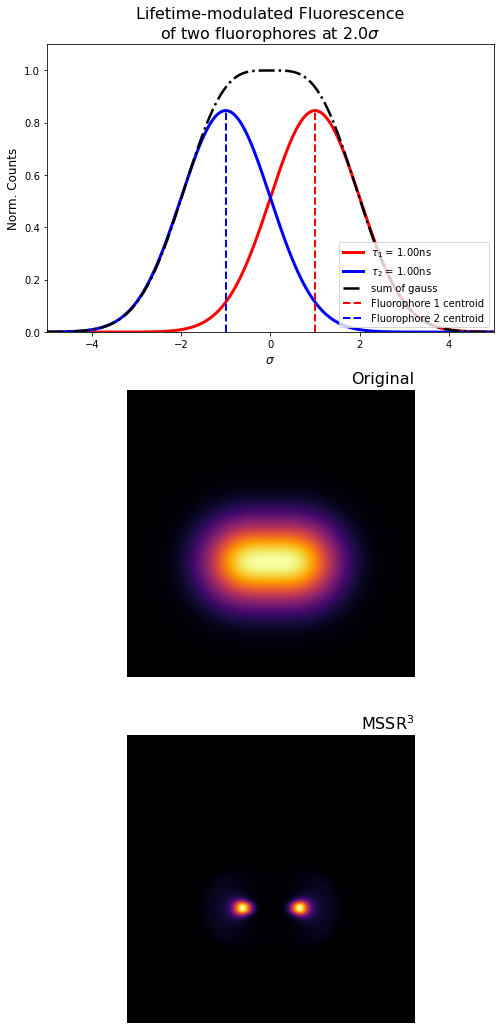

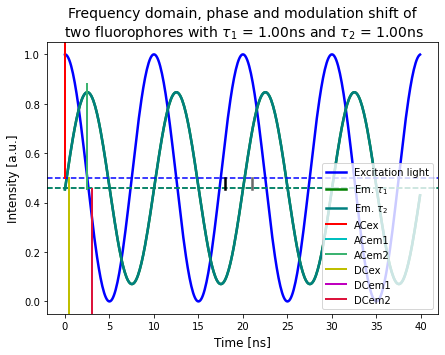

The value of Mod(τ_1) as (ACem1/DCem1)/(ACex/DCex) is 0.8467 with an error of 0.0079 %
which gives a value of τ_1: 1.0003 ns with an error of 0.0277 %
The value of Mod(τ_2) as (ACem2/DCem2)/(ACex/DCex) is 0.8467 with an error of 0.0079 %
which gives a value of τ_2: 1.0003 ns with an error of 0.0277 %
τ_2 is 1.00 times larger than τ_1 
so its Modulation is 1.00 times shorter


In [14]:
# First the FD-FLIM part
E_0 = 1 #Steady-state intensity. Arbitrary units
E_w = 1 #Amplitude of the time-varying intensity. Arbitrary units
T = 10 # time in nanoseconds. Period of repetition of the excitation light, for a 1.0 ns probe one can use ~100MHz frequency, so 10 ns
phi_E = 0 #phase of the excitation light. angle in grads
### Function E(t) ###
w = (2*np.pi)/T
t = np.arange(0, 40, 0.1)
E_t = E_0 + E_w*np.cos(w*t + phi_E)
### Emission F(t) ###
# The fluorescence emission at time , t is
# F(t) = E_0*a_s*tau_s + E_w*a_s*tau_s*Ms*cos(w*t + phi_E - phi_F)
F = 100000000                                   # Frequency of the excitation light. In Hz
a_s = 1.0                                       # fractional number from 0.0 to 1.0 indicating how much of the signal
                                                # corresponds to a specific fluorophore emission 
tau_1 = float(input('Enter a fluorescence lifetime, \u03C4_1, in ns (from 0.05 to 100, two decimal figures allowed): '))  # lifetime in ns
tau_2 = float(input('Enter a fluorescence lifetime, \u03C4_2, in ns (from 0.05 to 100, two decimal figures allowed): '))  # lifetime in ns
Ms_1 = 1 / np.sqrt(1 + (w*tau_1)**2)
Ms_2 = 1 / np.sqrt(1 + (w*tau_2)**2)
phi_F1 = np.radians(2*np.pi*F*tau_1)             # phi_F is the phase in rad from the tau_s as
                                                 # phi_F = 2*pi*F*tau_s, where F for tau = 1.0ns is 100MHz = 100 000 000 s^(-1)
phi_F2 = np.radians(2*np.pi*F*tau_2)
F_t1 = E_0*a_s*tau_1 + E_w*a_s*tau_1*Ms_1*np.cos(w*t + phi_E - phi_F1)
F_t2 = E_0*a_s*tau_2 + E_w*a_s*tau_2*Ms_2*np.cos(w*t + phi_E - phi_F2)
# Let's normalize the functions above #
max_E = max(E_t)
norm_E = E_t/max_E
max_F1 = max(F_t1)
norm_F1 = F_t1/max_F1                 # Normalized F_t1 but it has a maximum value of 1.0, so the entire plot is levered to that number
mod_F1 = (F_t1/max_F1)*Ms_1           # Multiplying norm_F1 by the modulation Ms_1, then it returns the plot to the maximum value of M_f
max_F2 = max(F_t2)
norm_F2 = F_t2/max_F2                 # Normalized F_t2 but it has a maximum value of 1.0, so the entire plot is levered to that number
mod_F2 = (F_t2/max_F2)*Ms_2
# Adding the AC/DC lines to calculate the modulation shift #
mean_E = np.mean(norm_E)
mean_F1 = np.mean(mod_F1)
max_E = max(norm_E)
max_F1 = max(mod_F1)
mean_F2 = np.mean(mod_F2)
max_F2 = max(mod_F2)
### AC lines ###
ACex = max_E - mean_E
ACem1 = max_F1 - mean_F1
ACem2 = max_F2 - mean_F2
DCex = mean_E - 0.0
DCem1 = mean_F1 - 0.0
DCem2 = mean_F2 - 0.0
### Modulation and lifetime from AC/DC ratio ###
Mod1 = (ACem1/DCem1)/(ACex/DCex)
tau_mod1 = (np.sqrt(1 - Mod1**2))/(Mod1*w)
Mod2 = (ACem2/DCem2)/(ACex/DCex)
tau_mod2 = (np.sqrt(1 - (Mod2)**2))/(Mod2*w)
### Error calculation ###
Mod1_err = (abs(Ms_1-Mod1)/Ms_1)*100
tau1_err = (abs(tau_1-tau_mod1)/tau_1)*100
Mod2_err = (abs(Ms_2-Mod2)/Ms_2)*100
tau2_err = (abs(tau_2-tau_mod2)/tau_2)*100
#From the above, the most important part is the Mod value which is going to be multiplied by the normalized gauss
# Calculation of rMod from the equation
# rMod = 0.5316*rtau + 0.4684, where rMod = Mod(tau_1)/Mod(tau_2)
rtau = tau_mod2/tau_mod1
rMod = 0.5316*rtau + 0.4684
# Now, the gauss part
n = 5
x = np.arange(-n, n, 0.01)
#mu1 = float(input('Enter a value in which you whish the gaussian function to be centered (from 0 to 1000 in multiples of 100): '))
#s1 = float(input('Enter a width (standard deviation) value for the gaussian function (from 0 to 500 in multiples of 50): '))
s1 = 1.0
mu1 = 1.0
mu2 = -mu1

s2 = s1
gauss1 = [1 / (s1*np.sqrt(2*np.pi))] * np.exp((-1/2)*((x-mu1)/s1)**2)
gauss2 = [1 / (s2*np.sqrt(2*np.pi))] * np.exp((-1/2)*((x-mu2)/s2)**2)
norm1 = max(gauss1)
norm2 = max(gauss2)
gaussian1 = gauss1/norm1
gaussian2 = gauss2/norm2
mod1_gauss1 = Mod1*gaussian1
mod2_gauss2 = Mod2*gaussian2
gauss3 = mod1_gauss1 + mod2_gauss2
norm3 = max(gauss3)
gaussian3 = (gauss3/norm3)
d = mu1 -(mu2)               #the distance of the two centers
# convert to image #
img = np.outer(gaussian1, gaussian3)
### plotting ###
#gaussian plots
plt.figure(figsize=(8,18))
plt.subplot(3,1,1)
plt.plot(x, mod1_gauss1, color = 'r' , linewidth = 3.0, label = '$\u03c4_1$ = {:.2f}ns'.format(tau_1))
plt.plot(x, mod2_gauss2, color = 'b', linewidth = 3.0, label = '$\u03c4_2$ = {:.2f}ns'.format(tau_2))
plt.plot(x, gaussian3, color = 'k', linewidth =2.5, linestyle='dashdot', label = 'sum of gauss')
plt.axvline(mu1, 0.0, max(mod1_gauss1)-0.08, color = 'r', linestyle = '--', linewidth = 2.0, label = 'Fluorophore 1 centroid')      #plotting the fluorophore 1 centroid
plt.axvline(mu2, 0.0, max(mod2_gauss2)-0.08, color = 'b', linestyle = '--', linewidth = 2.0, label = 'Fluorophore 2 centroid')      #plotting the fluorophore 2 centroid
plt.axis([-n, n, 0.0, max(gaussian1) + 0.1])
plt.xlabel('$\u03c3$', fontsize=12)
plt.ylabel('Norm. Counts', fontsize=12)
plt.title('Lifetime-modulated Fluorescence\nof two fluorophores at {:.1f}$\u03c3$'.format(d), fontsize=16)
plt.legend(loc = 4)
plt.subplot(3,1,2)
plt.title('Original', loc = 'right', fontsize=16)
plt.imshow(img, cmap='inferno')  
plt.axis('off')
#Performing sfMSSR on the image above
mssr_order = 3
imagenmssr = sfMSSR(img, 500, 1.0, mssr_order, mesh = True, ftI = False, intNorm = True)
plt.subplot(3,1,3)
plt.title('MSSR$^{:.0f}$'.format(mssr_order), loc = 'right', fontsize=16)
im = plt.imshow(imagenmssr, cmap='inferno')
plt.axis('off')
plt.savefig('FLDistr_2fluor_at{:.0f}nm_MSSR{:.0f}.tif'.format(d,mssr_order))
plt.show()
#FD-FLIM plot
plt.figure(figsize=(7,5))
plt.plot(t, norm_E, color = 'b', linewidth = 2.5, label = 'Excitation light')
plt.plot(t, mod_F1, color = 'g', linewidth = 2.5, label = 'Em. $\u03c4_1$')
plt.plot(t, mod_F2, color = 'teal', linewidth = 2.5, label = 'Em. $\u03c4_2$')
plt.axhline(mean_E, 0, 4, color = 'b', linestyle = '--')
plt.axhline(mean_F1, 0, 4, color = 'g', linestyle = '--')
plt.axhline(mean_F2, 0, 4, color = 'teal', linestyle = '--')
plt.axvline(np.argmax(norm_E), mean_E, max(norm_E), color = 'r', linestyle = '-', linewidth = 2.0, label = 'ACex')            #plotting ACex
plt.axvline(0.1*np.argmax(mod_F1), mean_F1, max(mod_F1), color = 'c', linestyle = '-', linewidth = 2.0, label = 'ACem1')          #plotting ACem
plt.axvline(0.1*np.argmax(mod_F2), mean_F2, max(mod_F2), color = 'mediumseagreen', linestyle = '-', linewidth = 2.0, label = 'ACem2')
plt.axvline(np.argmax(norm_E) + 0.5, 0.0, mean_E, color = 'y', linestyle = '-', linewidth = 2.0, label = 'DCex')              #Plotting DCex
plt.axvline(0.1*np.argmax(mod_F1) + 0.5, 0.0, mean_F1, color = 'm', linestyle = '-', linewidth = 2.0, label = 'DCem1')           #Plotting DCem
plt.axvline(0.1*np.argmax(mod_F2) + 0.5, 0.0, mean_F2, color = 'crimson', linestyle = '-', linewidth = 2.0, label = 'DCem2')
plt.axvline(18, mean_F1, mean_E, color = 'k', linestyle = '-', linewidth = 2.5)
plt.axvline(21, mean_F2, mean_E, color = 'dimgrey', linestyle = '-', linewidth = 2.5)
#plt.annotate('Mod', xy=(19,0.47), xytext=(13, 0.95), arrowprops=dict(facecolor='black', shrink=0.05), fontsize = 11)
plt.title('Frequency domain, phase and modulation shift of\n two fluorophores with $\u03c4_1$ = {:.2f}ns and $\u03c4_2$ = {:.2f}ns'.format(tau_1, tau_2), fontsize = 14)
plt.xlabel("Time [ns]", fontsize = 12)
plt.ylabel("Intensity [a.u.]", fontsize = 12)
plt.legend(loc = 4)
#plt.savefig('FD_FLIM.tif')
plt.show()
#print('The value of Ms_1 is {:.4f}'.format(Ms_1))
#print('The value of Ms_2 is {:.4f}'.format(Ms_2))
print('The value of Mod(\u03c4_1) as (ACem1/DCem1)/(ACex/DCex) is {:.4f} with an error of {:.4f} %'.format(Mod1,Mod1_err))
print('which gives a value of \u03C4_1: {:.4f} ns with an error of {:.4f} %'.format(tau_mod1,tau1_err))
print('The value of Mod(\u03c4_2) as (ACem2/DCem2)/(ACex/DCex) is {:.4f} with an error of {:.4f} %'.format(Mod2,Mod2_err))
print('which gives a value of \u03C4_2: {:.4f} ns with an error of {:.4f} %'.format(tau_mod2,tau2_err))
print('\u03c4_2 is {:.2f} times larger than \u03c4_1 \nso its Modulation is {:.2f} times shorter'.format(rtau, rMod))